In [55]:
import pandas as pd
import requests
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline
import json
from matplotlib.colors import rgb2hex, colorConverter

In [43]:
with open('headers.json', 'w') as fp:
    json.load(headers, fp)

**Importing Data**

In [ ]:
# get ids of top rated 250 movies (saved as movies.csv)
url_movies = "https://imdb8.p.rapidapi.com/title/get-top-rated-movies"


response_movies = requests.request("GET", url_movies, headers=headers)


In [ ]:
# get ids of top rated 250 tv shows (saved as tv.csv)
url_tv = "https://imdb8.p.rapidapi.com/title/get-top-rated-tv-shows"

response_tv = requests.request("GET", url_tv, headers=headers)


In [358]:
# movies = movies.sample(frac=0.50)
# tv = tv.sample(frac=0.50)
# ids = pd.concat([movies,tv]).reset_index(drop=True) (saved as ids.csv)

In [ ]:
# get the plots of the movies and serials
# free IMDb API only allows 500 calls per month thereby half of the random sample

url = "https://imdb8.p.rapidapi.com/title/get-plots"

plot = pd.DataFrame()
for x in ids["title_id"]:
    querystring = {"tconst":x}
    response = requests.request("GET", url, headers=headers, params=querystring)
    df = pd.json_normalize(response.json()["plots"])
    plot = pd.concat([plot,df])

In [ ]:
# get the title_id of plots, here we could also use keys base. do not have enough API call remaining
title = []
for x in plot["id"]:
    x = re.search("/title/(.*)/plot/[\w]", x)
    title.append(x.group(1))
plot["title_id"] = title

In [ ]:
# after extracting plots, below codes have been run and saved as df.csv
# df = pd.merge(plot,ids,how='left',on=["title_id"])
# df = df.groupby(["title_id","title"])["text"].apply(','.join).reset_index()

In [8]:
# read csv for ids and df
ids = pd.read_csv("ids.csv",index_col=0) #ids of movies
df = pd.read_csv("df.csv",index_col=0) # plot of movies on id level, below cell shows how it was extracted
movies = pd.read_csv("movies.csv",index_col=0) # movie names with title

In [9]:
# extract the IDs to use in API call for plots
title_id = []
for x in ids["id"]:
    x = re.search("/title/(.*)/", x)
    title_id.append(x.group(1))
ids["title_id"] = title_id

In [18]:
# scraping title names

language = {'Accept-Language': 'en-US, en;q=0.5'}

imdb_titles = []
for i in ids['title_id']:
    
    title_url = "https://www.imdb.com/title/" + i + "/"

    r = requests.get(url=title_url,headers=language)
    # create a BeautifulSoup object
    soup = BeautifulSoup(r.text, 'html.parser')
    title = soup.find("title")
    imdb_titles.append(title.string)

In [19]:
titles = []
for y in imdb_titles:
    z = re.findall('^[^\(]+',y)
    titles.append(z)
titles = [item.strip() for sublist in titles for item in sublist]
movies['title'] = titles[0:250]

In [21]:
df = pd.merge(df,ids,on=["title_id"]) # merge df and ids to have titles and plots at the same dataframe
df = df[df["type_x"]=="movie"].reset_index(drop=True)[["title","text"]] # first 125 movies that their synopsis were extracted

In [22]:
# importing additional data from kaggle in order to find plots that we could not extract with API because of 500 call limit
data = pd.read_csv("tmdb_5000_movies.csv") # importing additional data from kaggle in order to

data = data[["original_title","overview"]].dropna().reset_index(drop=True)

data.rename(columns={"original_title":"title"},inplace=True)

data2 = pd.merge(data,df,how="outer",on=["title"]) # mergind imdb data with csv data

data2["plot"] = np.where(data2["text"].isnull(),data2["overview"],data2["text"])

data2 = data2[["title","plot"]]

data2 = data2.groupby("title")["plot"].apply(','.join).reset_index()

data3 = pd.merge(data2,movies,how="right",on="title") # merge data3 with movies to get title_id as remaining NaN(s) will be filled with remaining calls in API

In [ ]:
# plots of the movies with API. These are for the movies that we did not extract their plots in first API call
# and could not be also found in csv outsource dataset

url = "https://imdb8.p.rapidapi.com/title/get-plots"

movies2 = pd.DataFrame()
for x in data3[data3.isna().any(axis=1)]["title_id"]:
    querystring = {"tconst":x}
    response = requests.request("GET", url, headers=headers, params=querystring)
    plots = pd.json_normalize(response.json()["plots"])
    movies2 = pd.concat([movies2,plots])

In [23]:
movies2 = pd.read_csv("movies2.csv")

In [24]:
title = []
for x in movies2["id"]:
    x = re.search("/title/(.*)/plot/[\w]", x)
    title.append(x.group(1))
movies2["title_id"] = title
movies3 = movies2.groupby("title_id")["text"].apply(','.join).reset_index() #group by title_ids to merge synopsis

In [25]:
#top 250 movies and their plots
final = pd.merge(data3,movies3,on=["title_id"],how="outer") 
final["plot"] = np.where(final["text"].isnull(),final["plot"],final["text"])
final = final[["title","plot"]]

In [45]:
final = pd.read_csv("final.csv",index_col=0)

**NLP Process**

- tokenization
- stemming

In [46]:
stemmer = SnowballStemmer("english")

# Define a function to perform both stemming and tokenization
def token_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(t) for t in filtered_tokens]
    
    return stems

**Term Frequency Inverse Document Frequency**

In [47]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=200000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=token_and_stem,
                                 ngram_range=(1,3))

In [48]:
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in final["plot"]])

print(tfidf_matrix.shape)

(250, 2673)


**Creating Clusters**

In [49]:
# Create a KMeans object with 5 clusters and save as km
km = KMeans(n_clusters=5)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
final["clusters"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
final["clusters"].value_counts() 

2    77
3    51
0    46
1    44
4    32
Name: clusters, dtype: int64

**Similarity Distance and Dendrogram**

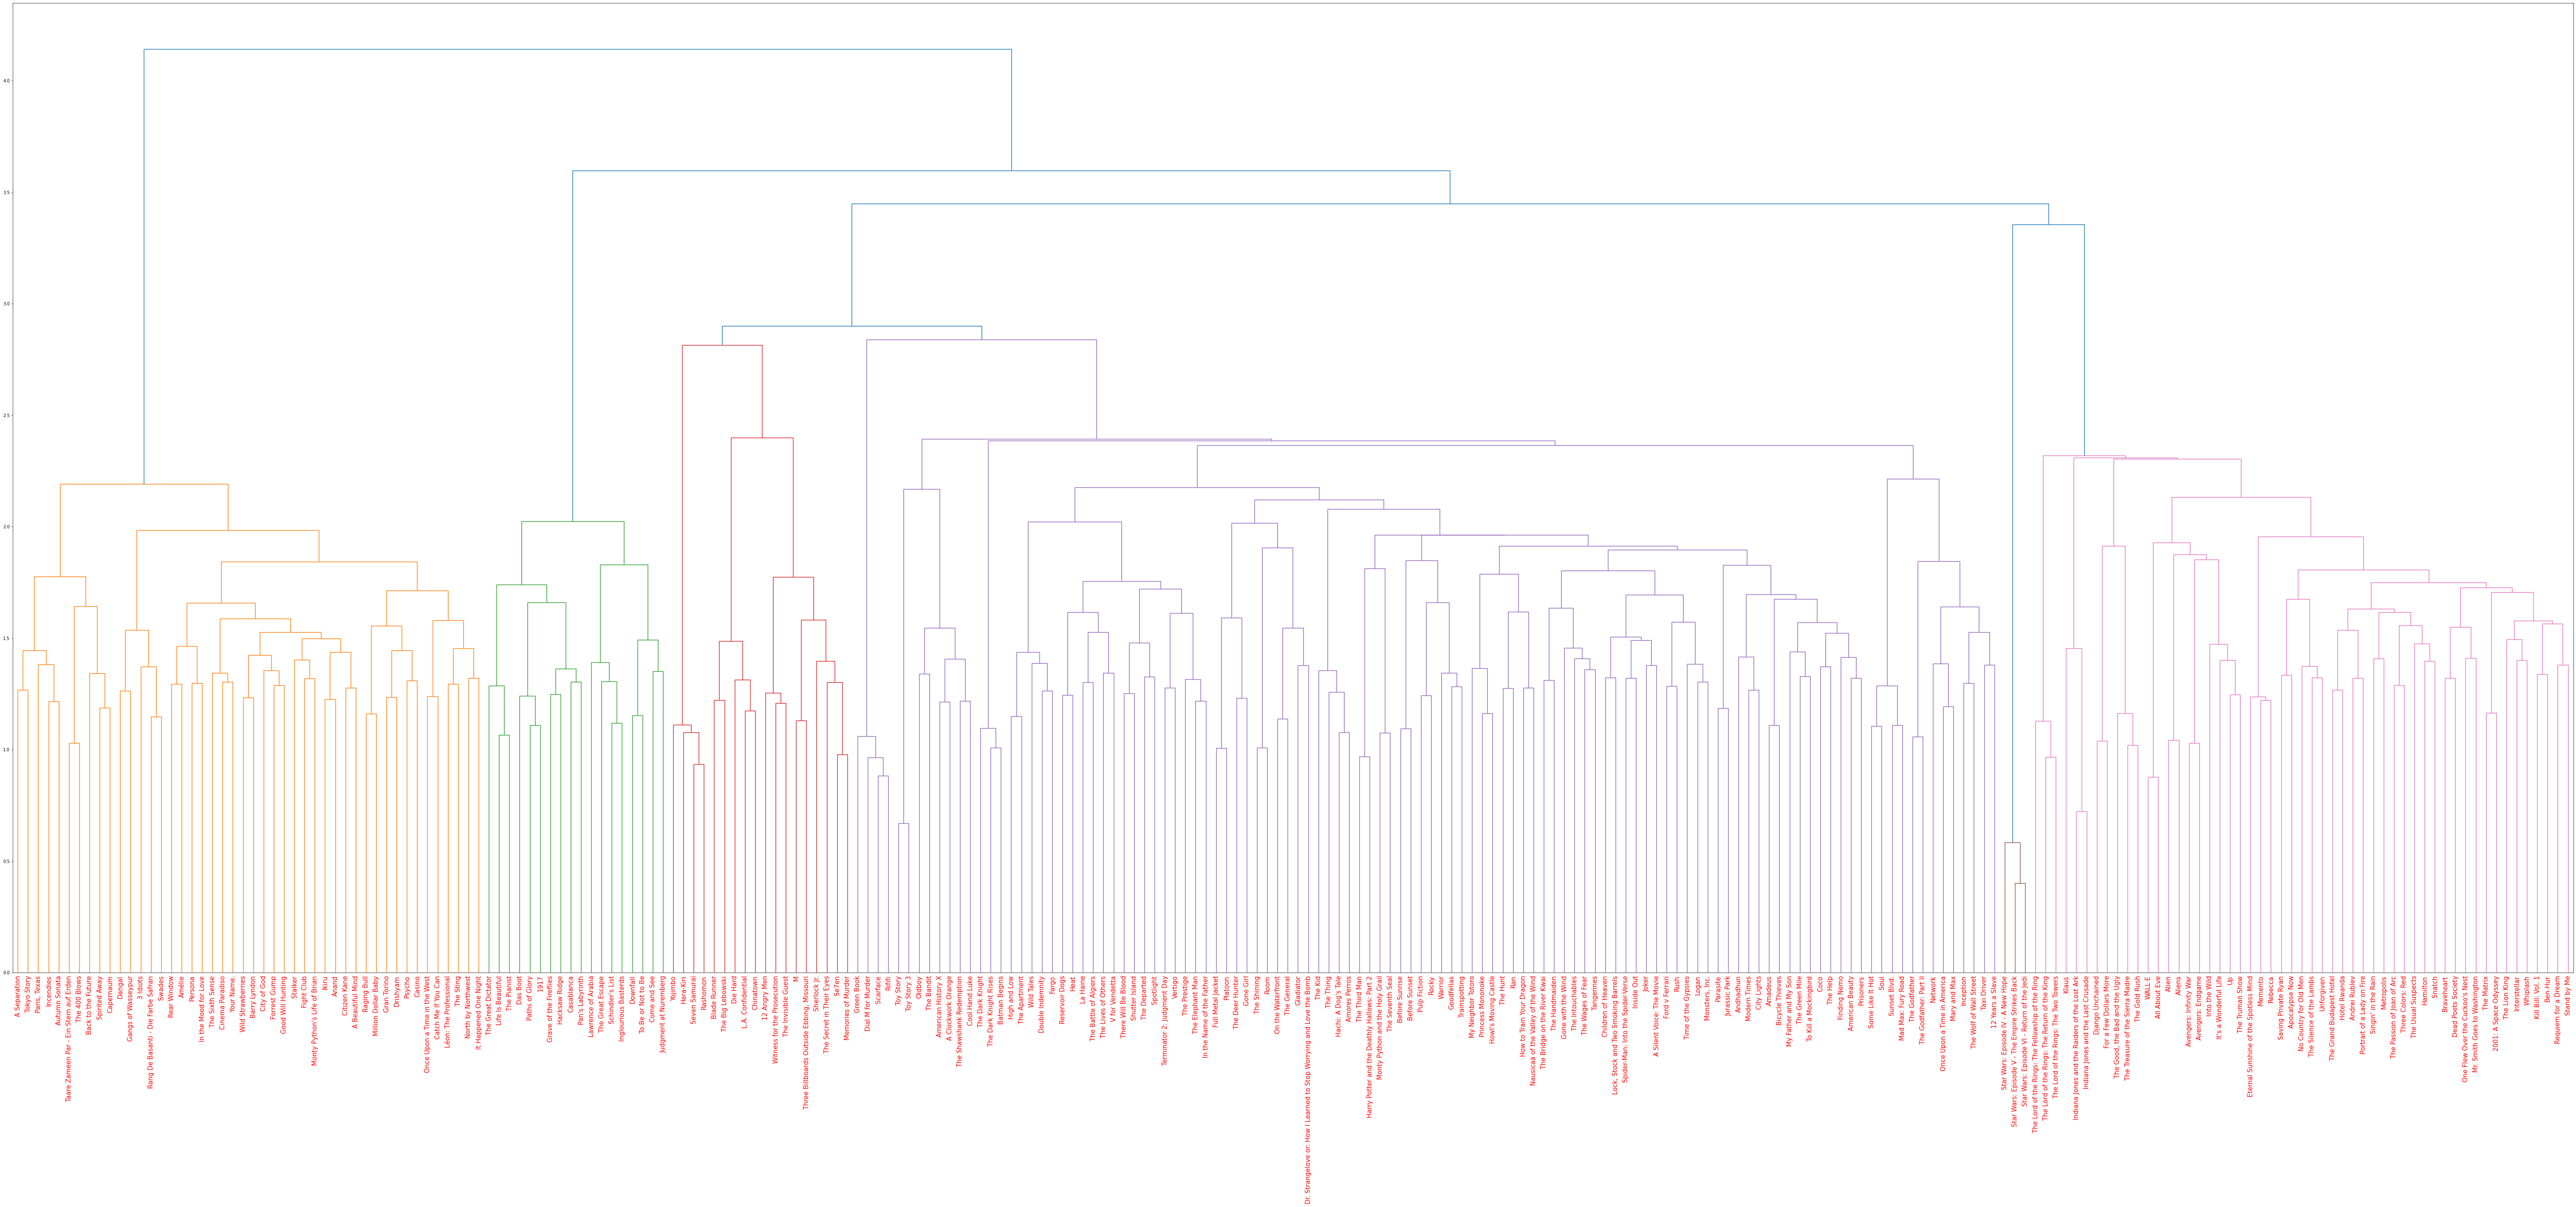

In [50]:
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

# Create mergings matrix 
Z = linkage(similarity_distance, method='ward')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(Z,
               labels=[x for x in final["title"]],
               leaf_rotation=90,
               leaf_font_size=15,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 42)

# Show the plotted dendrogram
plt.show()

In [51]:
from collections import defaultdict
cluster_idxs = defaultdict(list)
for c, pi in zip(dendrogram_['color_list'], dendrogram_['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs[c].append(int(i))

In [52]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

In [56]:
cluster_classes = Clusters()
for c, l in cluster_idxs.items():
    i_l = [dendrogram_['ivl'][i] for i in l]
    cluster_classes[c] = i_l

cluster_classes

{'C1': ['A Separation',
  'Tokyo Story',
  'Incendies',
  'Autumn Sonata',
  'Paris, Texas',
  'Taare Zameen Par - Ein Stern auf Erden',
  'The 400 Blows',
  'Spirited Away',
  'Capernaum',
  'Back to the Future',
  'Dangal',
  'Gangs of Wasseypur',
  'Rang De Basanti - Die Farbe Safran',
  'Swades',
  '3 Idiots',
  'Rear Window',
  'Amélie',
  'Persona',
  'In the Mood for Love',
  'Cinema Paradiso',
  'Your Name.',
  'The Sixth Sense',
  'Wild Strawberries',
  'Barry Lyndon',
  'Forrest Gump',
  'Good Will Hunting',
  'City of God',
  'Fight Club',
  "Monty Python's Life of Brian",
  'Stalker',
  'Ikiru',
  'Anand',
  'Citizen Kane',
  'A Beautiful Mind',
  'Raging Bull',
  'Million Dollar Baby',
  'Gran Torino',
  'Drishyam',
  'Psycho',
  'Casino',
  'Once Upon a Time in the West',
  'Catch Me If You Can',
  'Léon: The Professional',
  'The Sting',
  'North by Northwest',
  'It Happened One Night',
  'Gran Torino',
  'Léon: The Professional',
  'Casino'],
 'C2': ['Life Is Beautiful',
  'The Pianist',
  'The Great Dictator',
  'Paths of Glory',
  '1917',
  'Das Boot',
  'Grave of the Fireflies',
  'Hacksaw Ridge',
  'Casablanca',
  "Pan's Labyrinth",
  "Schindler's List",
  'Inglourious Basterds',
  'The Great Escape',
  'Lawrence of Arabia',
  'Downfall',
  'To Be or Not to Be',
  'Come and See',
  'Judgment at Nuremberg'],
 'C3': ['Seven Samurai',
  'Rashomon',
  'Hara-Kiri',
  'Yojimbo',
  'Blade Runner',
  'The Big Lebowski',
  'L.A. Confidential',
  'Chinatown',
  'Die Hard',
  'Witness for the Prosecution',
  'The Invisible Guest',
  '12 Angry Men',
  'M',
  'Three Billboards Outside Ebbing, Missouri',
  'Se7en',
  'Memories of Murder',
  'The Secret in Their Eyes',
  'Sherlock Jr.'],
 'C4': ['Scarface',
  'Rififi',
  'Dial M for Murder',
  'Green Book',
  'Toy Story',
  'Toy Story 3',
  'Oldboy',
  'The Bandit',
  'American History X',
  'A Clockwork Orange',
  'The Shawshank Redemption',
  'Cool Hand Luke',
  'American History X',
  'The Dark Knight Rises',
  'Batman Begins',
  'The Dark Knight',
  'High and Low',
  'The Apartment',
  'Double Indemnity',
  'Fargo',
  'Wild Tales',
  'Reservoir Dogs',
  'Heat',
  'La Haine',
  'The Battle of Algiers',
  'The Lives of Others',
  'V for Vendetta',
  'There Will Be Blood',
  'Shutter Island',
  'The Departed',
  'Spotlight',
  'Terminator 2: Judgment Day',
  'Vertigo',
  'The Elephant Man',
  'In the Name of the Father',
  'The Prestige',
  'La Haine',
  'Full Metal Jacket',
  'Platoon',
  'The Deer Hunter',
  'Gone Girl',
  'The Shining',
  'Room',
  'On the Waterfront',
  'The General',
  'Gladiator',
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb',
  'On the Waterfront',
  "Hachi: A Dog's Tale",
  'Amores Perros',
  'The Thing',
  'The Kid',
  'The Third Man',
  'Harry Potter and the Deathly Hallows: Part 2',
  'Monty Python and the Holy Grail',
  'The Seventh Seal',
  'Before Sunrise',
  'Before Sunset',
  'Pulp Fiction',
  'Rocky',
  'Goodfellas',
  'Trainspotting',
  'Warrior',
  'Princess Mononoke',
  "Howl's Moving Castle",
  'My Neighbor Totoro',
  'The Hunt',
  'Ran',
  'How to Train Your Dragon',
  'Nausicaä of the Valley of the Wind',
  'The Bridge on the River Kwai',
  'The Handmaiden',
  'The Wages of Fear',
  'Tangerines',
  'The Intouchables',
  'Gone with the Wind',
  'Children of Heaven',
  'Lock, Stock and Two Smoking Barrels',
  'Spider-Man: Into the Spider-Verse',
  'Inside Out',
  'Joker',
  'A Silent Voice: The Movie',
  'Ford v Ferrari',
  'Rush',
  'Logan',
  'Monsters, Inc.',
  'Time of the Gypsies',
  'Spider-Man: Into the Spider-Verse',
  'Parasite',
  'Jurassic Park',
  'Modern Times',
  'City Lights',
  'Andhadhun',
  'Amadeus',
  'Bicycle Thieves',
  'The Green Mile',
  'To Kill a Mockingbird',
  'My Father and My Son',
  'Coco',
  'The Help',
  'American Beauty',
  'Prisoners',
  'Finding Nemo',
  'Some Like It Hot',
  'Soul',
  'Sunset Blvd.',
  'Mad Max: Fury Road',
  'The Godfather',
  'The Godfather: Part II',

In [ ]:
den = pd.DataFrame(dendrogram_["ivl"],columns=["title"])

In [ ]:
lst = [1,1,2,2,2,3,3,4,4,4,5,5,6,6,6,7,7,8,8,9,9,9,10,10,11,11,11,12,12,12,13,13,14,14,15,15,16,16,17,17,18,18,19,19,20,20,
      21,21,21,22,22,22,23,23,24,24,25,25,25,25,26,26,27,27,28,28,28,28,29,29,30,30,30,31,31,31,32,32,33,33,33,33,
      34,34,34,34,35,35,36,36,37,37,38,38,39,39,39,40,40,41,41,41,42,42,43,43,44,44,45,45,46,46,47,47,48,48,48,49,49,50,50,51,51,52,52,53,53,
      54,54,54,54,55,55,56,56,57,57,58,58,59,59,59,60,60,60,61,61,62,62,63,63,64,64,64,64,65,65,66,66,67,67,68,68,69,69,69,
      70,70,71,71,71,72,72,73,73,73,74,74,75,75,75,76,76,77,77,78,78,79,79,79,80,80,81,81,82,82,82,
      83,83,83,84,84,84,85,85,86,86,86,87,87,88,88,89,89,90,90,90,90,91,91,91,92,92,93,93,93,94,94,95,95,96,96,97,97,
      98,98,98,99,99,100,100,101,101,102,102,102,103,103,104,104]

In [ ]:
den["segment"] = lst

In [ ]:
final = pd.merge(final,den,on=["title"])
final = final.sort_values("title").reset_index(drop=True)